## Original Resampling function

def Resampling(image, newsize, roisize, meta=image ,origin = None, is_label = False):
    #isize = image.GetSize()
    ivs = image.GetSpacing()
    
    if image.GetNumberOfComponentsPerPixel() == 1:
        minmax = sitk.MinimumMaximumImageFilter()
        minmax.Execute(image)
        minval = minmax.GetMinimum()
    else:
        minval = None
    
    osize = (newsize, newsize )
    

    
    ovs = [ vs * s / os for vs, s, os in zip(ivs, roisize, osize) ]
    

    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(osize)
    if origin is not None:
        resampler.SetOutputOrigin(origin)
    else:
        resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputSpacing(ovs)
    if minval is not None:
        resampler.SetDefaultPixelValue(minval)
    if is_label:
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)

    resampled = resampler.Execute(image)

    return resampled

In [11]:
import glob
import SimpleITK as sitk
import numpy as np
from matplotlib import pyplot as plt

In [12]:
x = glob.glob(r"E:\slice\layers_1\image\case_00[0-9]*\image[0-9]_[2-3][0-9].mha")
Max = []
Min = []
for i in x:
    img = sitk.ReadImage(i)
    imgArry = sitk.GetArrayFromImage(img)
    #imgArry = np.array(imgArry, dtype=np.uint)
    Max.append(imgArry.max())
    Min.append(imgArry.min())

In [51]:
print(max(Max))
print(min(Min))

2560.7292162668896
-1067.032712633945


CT max 3254.849292992295<br>
CT min-1253.8384597608458<br>

In [2]:
import SimpleITK as sitk
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [201]:
img = sitk.ReadImage(r"E:/kits19/data/case_00001/imaging.nii.gz")
imgArrays = sitk.GetArrayFromImage(img)

In [202]:
def makeCDF(imgArrayList, alpha = 0):#imgArrayList:int64
    imgArrayList = [ x + 1024 for x in imgArrayList ]
    
    imgArrayList = [np.where(x<0, 0, x) for x in imgArrayList]
    imgArrayList = [np.where(x>2048, 2048,x) for x in imgArrayList]
    
    ctRange = 2048 + 1
    #uniformDistribution = np.array([ctRange]*ctRange)
    
    HIST = np.array([0.0]*ctRange)
    for x in imgArrayList:
        hist, _  = np.histogram(x.flatten(), ctRange, [0, 2048+1])
        HIST += hist
    print(HIST)
    HIST = np.array(HIST * (1 - alpha) + alpha / HIST.max(), dtype=np.int64)    
    cdf = HIST.cumsum()
    cdf_m = np.ma.masked_equal(cdf,0)
    temp = (cdf_m - cdf_m.min())/(cdf_m.max()-cdf_m.min())
    cdf_m = 2048*temp
    cdf = np.ma.filled(cdf_m,0).astype('int64')
    
    return cdf,imgArrayList

In [203]:
def equalizingHistogram(imgArrayList, alpha):
    cdf, imgArrayList = makeCDF(imgArrayList, alpha)
    
    equalizedImageArrayList = []
    for imgAr in imgArrayList:
        x = cdf[imgAr] - 1024
        equalizedImageArrayList.append(x)
    
    return equalizedImageArrayList

In [204]:
imgArrayList = []
ctMax = -10**9
ctMin = 10**9
for x in range(len(imgArrays[0,0,:])):
    imgArry = np.array(imgArrays[:,:,x], dtype=np.int64)
    
    if imgArry.max()>ctMax:
        ctMax = imgArry.max()
    
    if imgArry.min()<ctMin:
        ctMin = imgArry.min()
    
    
    imgArrayList.append(imgArry)

In [205]:
#ctmax,ctmin,imgList(int型）は取得済み

zz = equalizingHistogram(imgArrayList, 0.75)
check = False
for x in zz:
    
    if check:
        img2Arrays = np.dstack([img2Arrays, x])
    
    else:
        check = True
        img2Arrays = x

#img2Arrays = img2Arrays - 1024
img2 = sitk.GetImageFromArray(img2Arrays)
img2.SetDirection(img.GetDirection())
img2.SetOrigin(img.GetOrigin())
img2.SetSpacing(img.GetSpacing())
sitk.WriteImage(img2, r"test/test_0.75.mha")

[1.117658e+06 8.380000e+04 4.634500e+04 ... 4.700000e+01 5.000000e+01
 5.177000e+03]


In [ ]:

#imgArrays += abs(imgArrays.min())
#fig, ax = plt.subplots(1, 2)
#ax[0].hist(imgArrays.flatten(), ctMax - ctMin + 1, [ctMin, ctMax - ctMin + 1])
#ax[1].hist(img2Arrays.flatten(), ctMax - ctMin + 1, [ctMin, ctMax - ctMin + 1 ],color="red")
plt.hist(imgArrays.flatten(), ctMax - ctMin + 1, [ctMin, ctMax - ctMin + 1 ],color="b")
plt.ylim([0,1000000])
#plt.xlim([-1000,3000])
plt.show()

Original


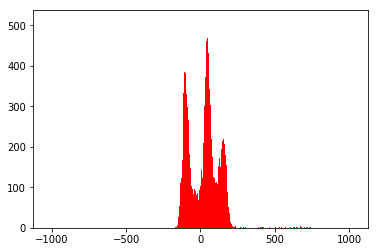

In [206]:
print("Original")
img = sitk.ReadImage(r"E:\slice\layers_1\image\case_00000\image0_11.mha")
img2Arrays = sitk.GetArrayFromImage(img)
plt.hist(img2Arrays.flatten(), 2049, [-1024, 1024],color="red")
#plt.xlim([-1000,3000])
plt.show()

alpha = 0.0


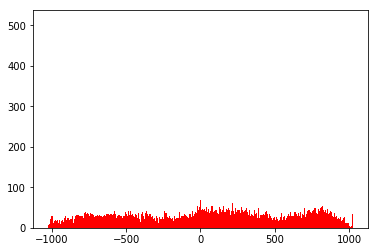

In [207]:
print("alpha = 0.0")
img = sitk.ReadImage(r"E:\slice\layers_1_hist_org\image\case_00000\image0_11.mha")
img2Arrays = sitk.GetArrayFromImage(img)
plt.hist(img2Arrays.flatten(), 2049, [-1024, 1024],color="red")
#plt.xlim([-1000,3000])
plt.show()

alpha = 0.25


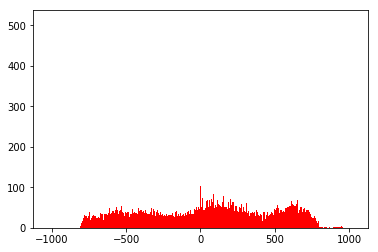

In [216]:
print("alpha = 0.25")
img = sitk.ReadImage(r"E:\slice\layers_1_hist_org_0.25\image\case_00000\image0_11.mha")
img2Arrays = sitk.GetArrayFromImage(img)
plt.hist(img2Arrays.flatten(), 2049, [-1024, 1024],color="red")
#plt.ylim([0,1000000])
#plt.xlim([-1000,3000])
plt.show()

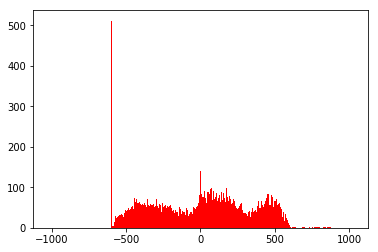

In [217]:
img = sitk.ReadImage(r"E:\slice\layers_1_hist_org_0.5\image\case_00000\image0_11.mha")
img2Arrays = sitk.GetArrayFromImage(img)
plt.hist(img2Arrays.flatten(), 2049, [-1024, 1024],color="red")
#plt.xlim([-1000,3000])
plt.show()

alpha = 0.75


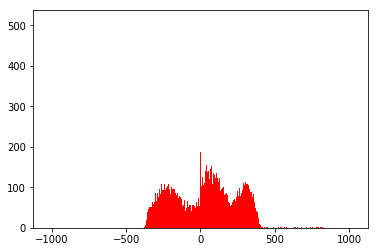

In [215]:
print("alpha = 0.75")
img = sitk.ReadImage(r"E:\slice\layers_1_hist_org_0.75\image\case_00000\image0_11.mha")
img2Arrays = sitk.GetArrayFromImage(img)
plt.hist(img2Arrays.flatten(), 2049, [-1024, 1024],color="red")
#plt.xlim([-1000,3000])
plt.show()

alpha = 1.0


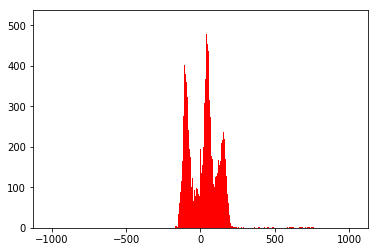

In [218]:
print("alpha = 1.0")
img = sitk.ReadImage(r"E:\slice\layers_1_hist_org_1.0\image\case_00000\image0_11.mha")
img2Arrays = sitk.GetArrayFromImage(img)
plt.hist(img2Arrays.flatten(), 2049, [-1024, 1024],color="red")
#plt.xlim([-1000,3000])
plt.show()

## Control data

In [27]:
small_mix = "000,004,006,009,010,011,014,015,016,018,021,022,026,029,033,034,036,039,040,041,046,051,052,054,057,059,061,062,065,066,071,075,076,082,083,085,086,087,095,096,097,098,100,104,105,108,111,113,115,116,117,118,119,122,123,126,128,131,132,136,138,140,142,144,147,148,150,151,153,154,156,157,158,159,160,163,166,167,168,169,171,174,175,176,177,198,201,203,204,207,208"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,109,139,149,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,042,056,070,079,088,114,135"
small_black = "001,002,003,007,013,017,019,027,031,032,035,038,043,044,045,048,050,053,064,068,072,077,080,089,090,091,094,099,101,103,106,110,121,124,127,129,130,133,146,162,164,170,173,185,187,196"

hard_mix = "020,023,049,063,081,120,156,191,209"

In [60]:
random.shuffle(smallMix)
random.shuffle(bigMix)
random.shuffle(bigBlack)
random.shuffle(smallBlack)
random.shuffle(hardMix)

In [1]:
import numpy as np
import random

In [91]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,049,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,156,191,209,057,098,150,057,098,150"
mix_with_black = "015,026,058,060,069,074,082,084,093,102,112,119,124,125,134,137,141,145,152,155,156,161,178,182,183,190,195,200"
special = "165,194,206,041,205,184,005,015,154,037,021,188,193,143,208,180,046"

In [33]:
true_small_mix = "000,006,014,016,041,052,059,071,075,082,087,095,096,097,100,115,117,118,122,128,131,132,140,142,147,159,160,163,167,169,177,203,204"
small_white="004,009,010,011,018,022,034,036,051,061,062,065,066,083,111,123,138,148,153,168,174,175,176,198"
big_mix = "008,012,030,047,055,067,073,078,092,102,107,108,109,139,149,157,172,178,179,181,186,189,192,197,199,202"
big_black = "024,025,028,029,042,056,070,079,088,113,114,116,135,166,171"
small_black = "001,002,003,007,013,017,019,027,031,032,033,035,038,039,040,043,044,045,048,050,053,064,068,072,076,077,080,085,086,089,090,091,094,099,101,103,104,105,106,110,121,124,126,127,129,130,133,136,144,146,151,158,162,164,170,173,185,187,196,201,207"

hard_mix = "020,023,049,054,063,081,120,191,209,057,098,150"
mix_with_black = "015,026,058,060,069,074,084,093,112,119,125,134,137,141,145,152,155,156,161,182,183,190,195,200"
special = "165,194,206,205,184,005,154,037,021,188,193,143,208,180,046"

In [34]:
a = len(true_small_mix.split(","))
b = len(small_white.split(","))
c = len(big_mix.split(","))
d = len(big_black.split(","))
e = len(small_black.split(","))
f = len(hard_mix.split(","))
g = len(mix_with_black.split(","))
h = len(special.split(","))
print(b)
print(a+b+c+d+e+f+g+h)

24
210


In [35]:
a = true_small_mix.split(",")
b = small_white.split(",")
c = big_mix.split(",")
d = big_black.split(",")
e = small_black.split(",")
f = hard_mix.split(",")
g = mix_with_black.split(",")
h = special.split(",")

print(sorted(a+b+c+d+e+f+g+h))
print(len(sorted(a+b+c+d+e+f+g+h)))
ss = sorted(a+b+c+d+e+f+g+h)

trueSmallMix = true_small_mix.split(",")
smallWhite = small_white.split(",")
bigMix = big_mix.split(",")
bigBlack = big_black.split(",")
smallBlack = small_black.split(",")
hardMix = hard_mix.split(",")
mixWithBlack = mix_with_black.split(",")
specialOne = special.split(",")
ignorePatient = ["005","151","165","194"]

#['015', '041', '049', '082', '102', '124', '156', '178']
loss = []
count = []
overlap = []
ignorePatient = ["005","151","165","194"]
for x in range(210):
    ss.count(str(x).zfill(3))
for x in range(210):
#     if str(x).zfill(3) in ignorePatient:
#         continue
        
    cnt = 0
    cnt += a.count(str(x).zfill(3))
    cnt += b.count(str(x).zfill(3))
    cnt += c.count(str(x).zfill(3))
    cnt += d.count(str(x).zfill(3))
    cnt += e.count(str(x).zfill(3))
    cnt += f.count(str(x).zfill(3))
    cnt += g.count(str(x).zfill(3))
    cnt += h.count(str(x).zfill(3))
    
    if cnt == 0:
        loss.append(str(x).zfill(3))
    
    if cnt>1:
        overlap.append(str(x).zfill(3))
        
    count.append(cnt)
print(overlap)
print(loss)
print(np.where(np.array(count)>0, True, False).sum())
print(count)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142'